Status: in progress (remarks will be available soon)

Remark: All the analysis is going to be aggregating all the data by hour, so doing it in that way, we can analyse all the years together and compare them

In [1]:
# packages 
import pandas as pd
import numpy as np
from pymongo import MongoClient
import missingno as msno 

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_theme(style="ticks")


/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_35309/773428529.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## connecting
db_name = "meteo_lasilla"
client = MongoClient("mongodb://localhost:27017/")
db = client[db_name] # meteo_paranal_test
collection = db[db_name]

## Counting Samples

In [3]:
print('Expected samples per year: ', 60*24*365) # asuming that we have un sample per minute

Expected samples per year:  525600


In [4]:

## samples per year
pipeline = [
    {   # it extracts the year from Date time
        "$project": { "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},}
    },
    { "$group": {# grouping by year and sum per sample 
            "_id": "$year",
            "count": {"$sum": 1}}
    },
    {"$sort": {"_id": 1}  # sort by year in ascending order
    }
]
result = list(collection.aggregate(pipeline))
for result_it in result:
    print(f"Year: {result_it['_id']}, Count: {result_it['count']}")

Year: 1991, Count: 2
Year: 1993, Count: 1935
Year: 1994, Count: 159651
Year: 1995, Count: 152038
Year: 1996, Count: 164892
Year: 1997, Count: 230500
Year: 1998, Count: 369322
Year: 1999, Count: 449286
Year: 2000, Count: 426784
Year: 2001, Count: 255628
Year: 2002, Count: 256237
Year: 2003, Count: 258165
Year: 2004, Count: 255047
Year: 2005, Count: 254790
Year: 2006, Count: 255003
Year: 2007, Count: 258633
Year: 2008, Count: 158175
Year: 2010, Count: 256111
Year: 2011, Count: 496978
Year: 2012, Count: 499619
Year: 2013, Count: 502408
Year: 2014, Count: 320822
Year: 2015, Count: 412360
Year: 2016, Count: 447534
Year: 2017, Count: 502776
Year: 2018, Count: 482943
Year: 2019, Count: 505830
Year: 2020, Count: 408280
Year: 2021, Count: 476174
Year: 2022, Count: 449252
Year: 2023, Count: 387030
Year: 2024, Count: 28100


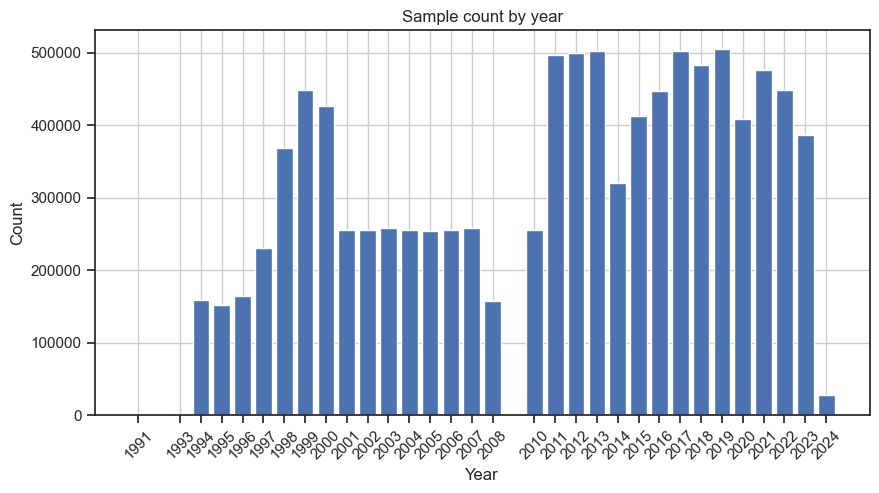

In [5]:
years = [result_it['_id'] for result_it in result]
counts = [result_it['count'] for result_it in result]

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(years, counts)
plt.xticks(years,rotation=45)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Sample count by year')
plt.grid(True)
plt.show()

In [6]:
## utils (skip this cell)
numeric_col = [
'Air Pressure at 2m [hPa]', 
'Air Pressure Normalised [hPa]', 
'Ambient Temperature at 30m [C]', 
'Ambient Temperature at 2m [C]', 
'Ambient Temperature at ground [C]', 
'Dew Temperature at 2m [C]', 
'Relative Humidity at 2m [%]', 
'Wind Direction at 30m [deg]', 
'Wind Direction at 10m [deg]', 
'Wind Speed at 30m [m/s]', 
'Wind Speed at 10m [m/s]'
 ]

def dict_to_datetime(x):
   return f"{x['year']}-{x['month']}-{x['day']} {x['hour']}:00:00"


def get_datetime_index(df):
    df['_id'] = pd.to_datetime(df['_id'].apply(dict_to_datetime))
    df = df.set_index(['_id'])
    df = df.sort_index(ascending=True)
    return df

def get_df(aggregated_expression):

    pipeline = [
        {"$group": {
                "_id": {
                    "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},
                    "month": {"$month": {"$dateFromString": {"dateString": "$Date time"}}},
                    "day": {"$dayOfMonth": {"$dateFromString": {"dateString": "$Date time"}}},
                    "hour": {"$hour": {"$dateFromString": {"dateString": "$Date time"}}},
                }, 
                **aggregated_expression}},
        {"$sort": {"_id.year": 1, "_id.month": 1, "_id.day": 1, "_id.hour": 1} }
    ]

    result = list(collection.aggregate(pipeline))

    return pd.DataFrame(result)



Remark: that pipeline calculate the average per period only in the numeric values. Nan values are not be considered:
https://www.mongodb.com/docs/manual/reference/operator/aggregation/avg/

In [7]:
## uploading data

# defining what we want
mean_agg = {f: {"$avg": f"${f}"} for f in numeric_col}
std_agg = {f: {"$stdDevSamp": f"${f}"} for f in numeric_col}
# min_agg = {f: {"$min": f"${f}"} for f in numeric_col}
# max_agg = {f: {"$max": f"${f}"} for f in numeric_col}

# getting df
df_mean = get_df(mean_agg)
df_std = get_df(std_agg)
# df_min = get_df(min_agg)
# df_max = get_df(max_agg)

# getting datetime index sorted
df_mean = get_datetime_index(df_mean)
df_std = get_datetime_index(df_std)
# df_min = get_datetime_index(df_min)
# df_max = get_datetime_index(df_max)


In [8]:
df=df_mean.copy() # just for save
print('DF shape: ',df.shape)
display(df.head(3))

DF shape:  (229363, 11)


,Air Pressure at 2m [hPa],Air Pressure Normalised [hPa],Ambient Temperature at 30m [C],Ambient Temperature at 2m [C],Ambient Temperature at ground [C],Dew Temperature at 2m [C],Relative Humidity at 2m [%],Wind Direction at 30m [deg],Wind Direction at 10m [deg],Wind Speed at 30m [m/s],Wind Speed at 10m [m/s]
_id,,,,,,,,,,,
1991-04-01 00:00:00,772.4,NaN,NaN,0.0,17.2,NaN,NaN,163.0,NaN,2.9,3.3
1991-04-01 01:00:00,0.0,NaN,NaN,0.0,NaN,NaN,NaN,97.0,NaN,0.0,0.0
1993-02-02 03:00:00,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0


In [142]:
# df.info()
# df.describe()

<Figure size 640x480 with 0 Axes>

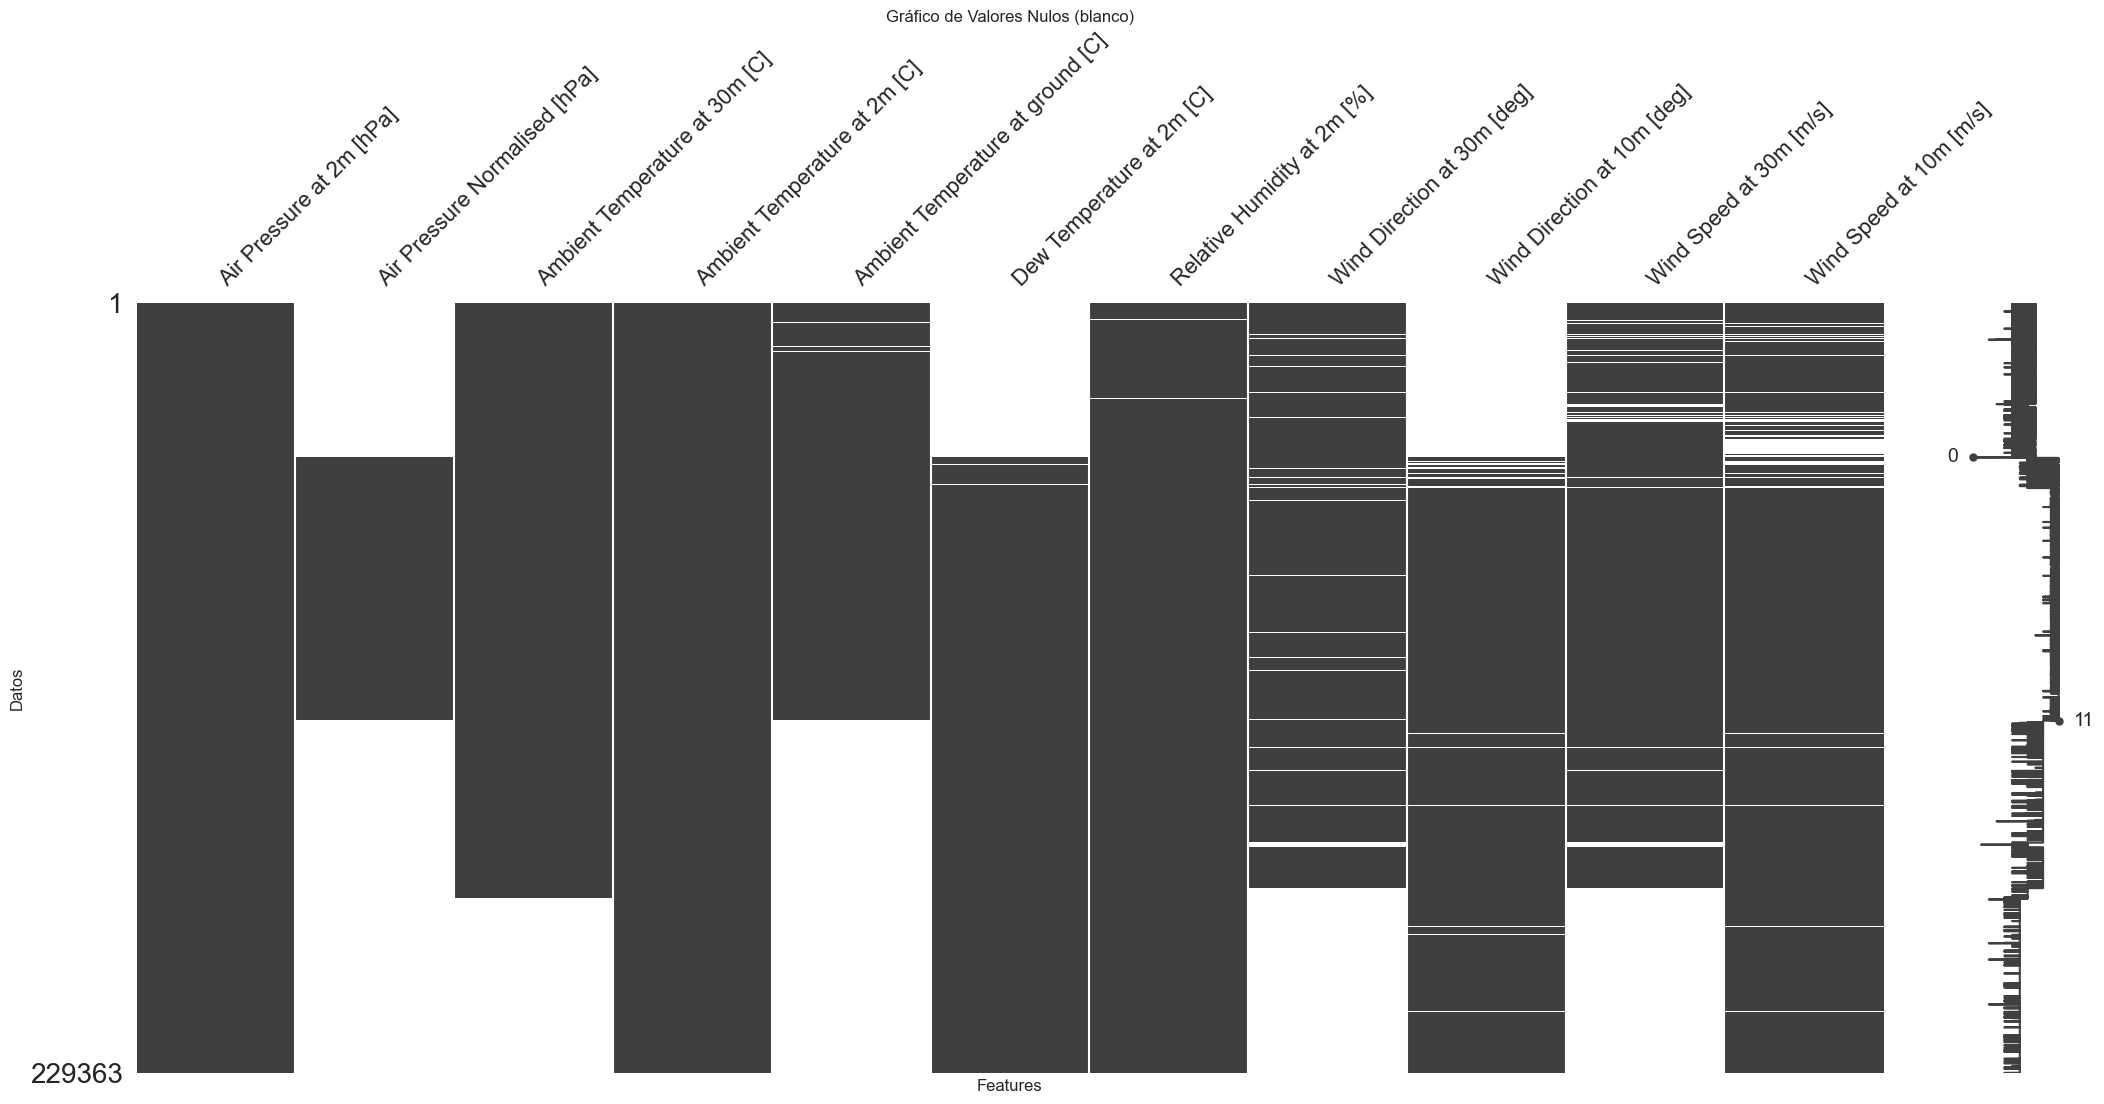

In [9]:
## general values of nan values
plt.clf()
msno.matrix(df)
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
plt.show()

In [10]:
df.isna().sum()

Air Pressure at 2m [hPa]                 13
Air Pressure Normalised [hPa]        151082
Ambient Temperature at 30m [C]        52550
Ambient Temperature at 2m [C]            79
Ambient Temperature at ground [C]    105363
Dew Temperature at 2m [C]             46551
Relative Humidity at 2m [%]            1001
Wind Direction at 30m [deg]           62095
Wind Direction at 10m [deg]           50252
Wind Speed at 30m [m/s]               63455
Wind Speed at 10m [m/s]               14478
dtype: int64

In [11]:
print('last record before nan values of ambien temperature at ground: ',df[df['Ambient Temperature at ground [C]'].notna()]['Ambient Temperature at ground [C]'].index[-1])

last record before nan values of ambien temperature at ground:  2008-08-16 20:00:00


In [17]:
print('first record of air pressure normalized: ',df[df['Air Pressure Normalised [hPa]'].notna()]['Air Pressure Normalised [hPa]'].index[0])

first record of air pressure normalized:  1999-07-05 09:00:00


this means we can use date range 2008-08-16 20:00:00 to 1999-07-05 09:00:00 and we will have almost all variables available at same time

<Figure size 640x480 with 0 Axes>

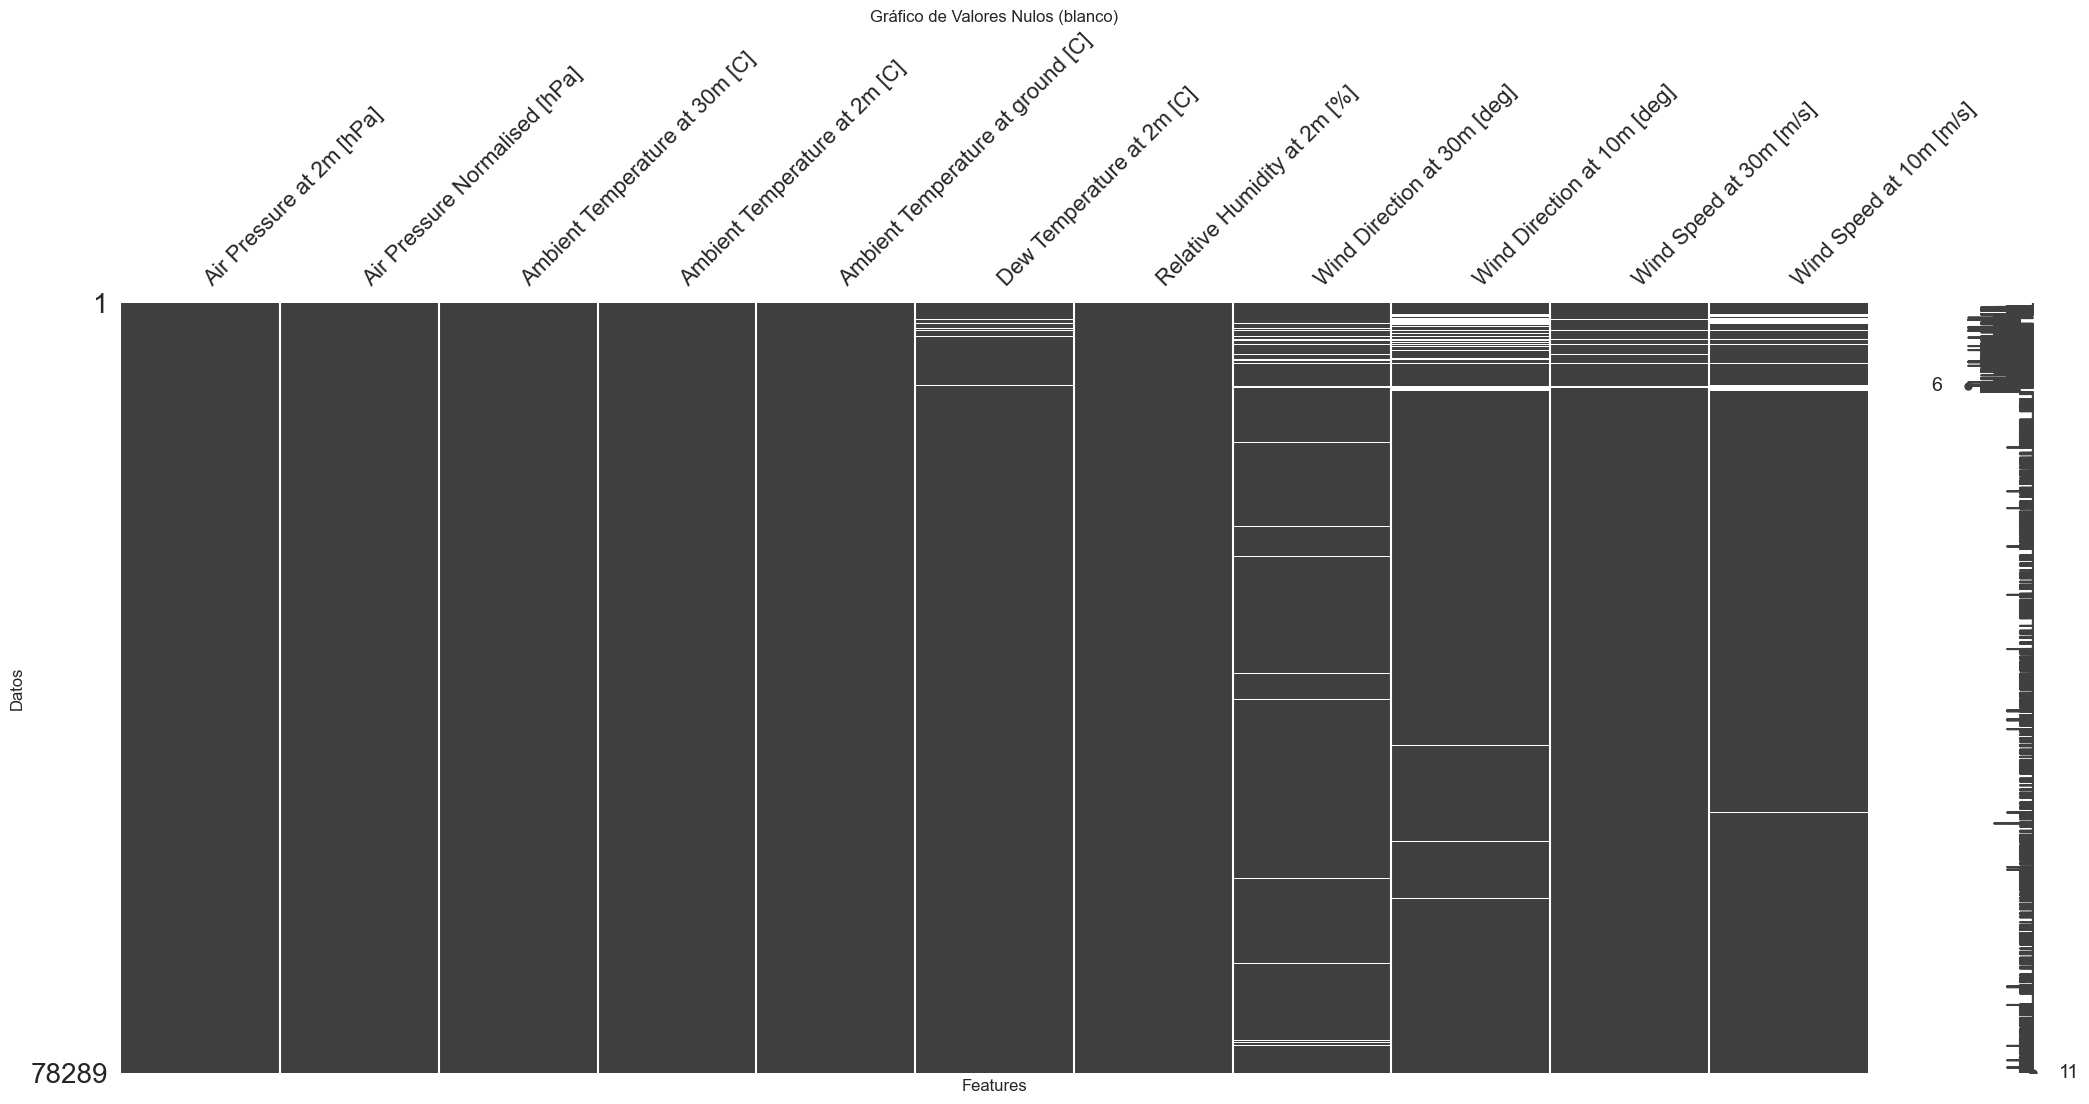

In [19]:
## general values of nan values
plt.clf()
msno.matrix(df.loc['1999-07-05 09:00:00':'2008-08-16 20:00:00'])
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
plt.show()

## Correlations

In [148]:
## getting principal correlations in excel format, located in corraltions/
top_negative_correlations,top_positive_correlations,less_correlated = get_principal_correlations(df.corr(),n_display=20)

/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_15775/2319257006.py:134: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]


In [12]:
display(top_negative_correlations.iloc[:10])
display(top_positive_correlations.iloc[:10])

NameError: name 'top_negative_correlations' is not defined

# Plot Analysis

## Historic Histogram

* Folder: ../plots/historic_histograms/

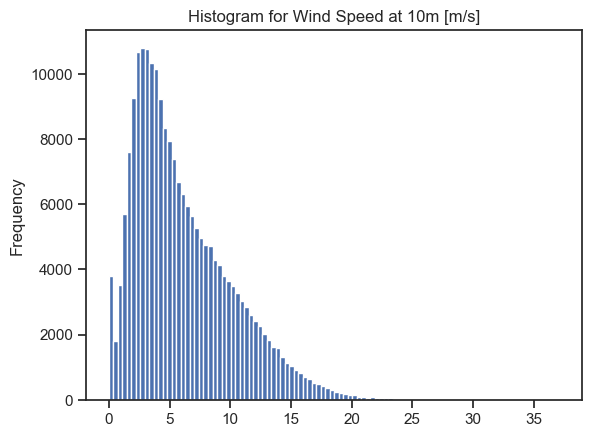

In [150]:
for variable in numeric_col:
    plot_historic_histogram(variable) # this function save the plot
    

## Histogram by year
* Folder: ../plots/histograms_per_year/

In [ ]:
for variable in numeric_col:
    plot_density_by_year(variable) # save the plot

## Scatterplot

<Figure size 640x480 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

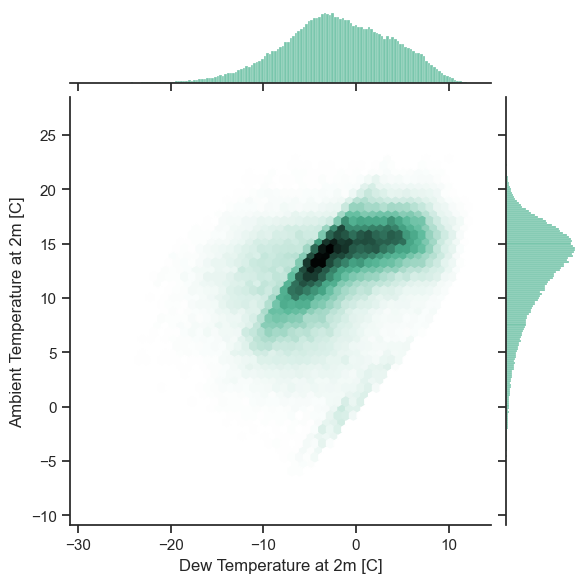

In [152]:
# Here I selected most interesting correlations I saw
# most correlated
pair1 = ('Relative Humidity at 2m [%]',	'Ambient Temperature at 2m [C]')


pairs = (
('Relative Humidity at 2m [%]',	'Ambient Temperature at 2m [C]'),
('Wind Speed at 30m [m/s]'	,'Ambient Temperature at 30m [C]'),
('Dew Temperature at 2m [C]',	'Ambient Temperature at ground [C]'),
('Relative Humidity at 2m [%]',	'Dew Temperature at 2m [C]'),
('Dew Temperature at 2m [C]',	'Ambient Temperature at 2m [C]')
         )
for pair in pairs:
    # plot_and_save_scatter(pair[0],pair[1])
    plot_and_save_hexbin(pair[0],pair[1])

Relative Humidity at 2m [%] and Ambient Temperature at 2m [C] which are the variables with more non-nan values, don't show a specific pattern historically, lets see for exmple in 2023 year

<Figure size 640x480 with 0 Axes>

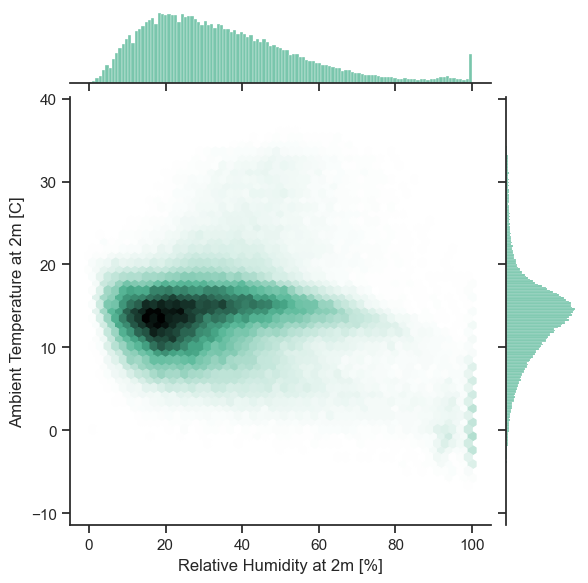

In [153]:
_df = df[df.index.year==2023]
variable1,variable2 = 'Relative Humidity at 2m [%]',	'Ambient Temperature at 2m [C]'
plt.clf()
sns.jointplot(x=df[variable1], y=df[variable2], kind="hex", color="#4CB391")
plt.xlabel(f'{variable1}')
plt.ylabel(f'{variable2}')
plt.show()

we got the same

## Historical Timeseries error

<Figure size 640x480 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

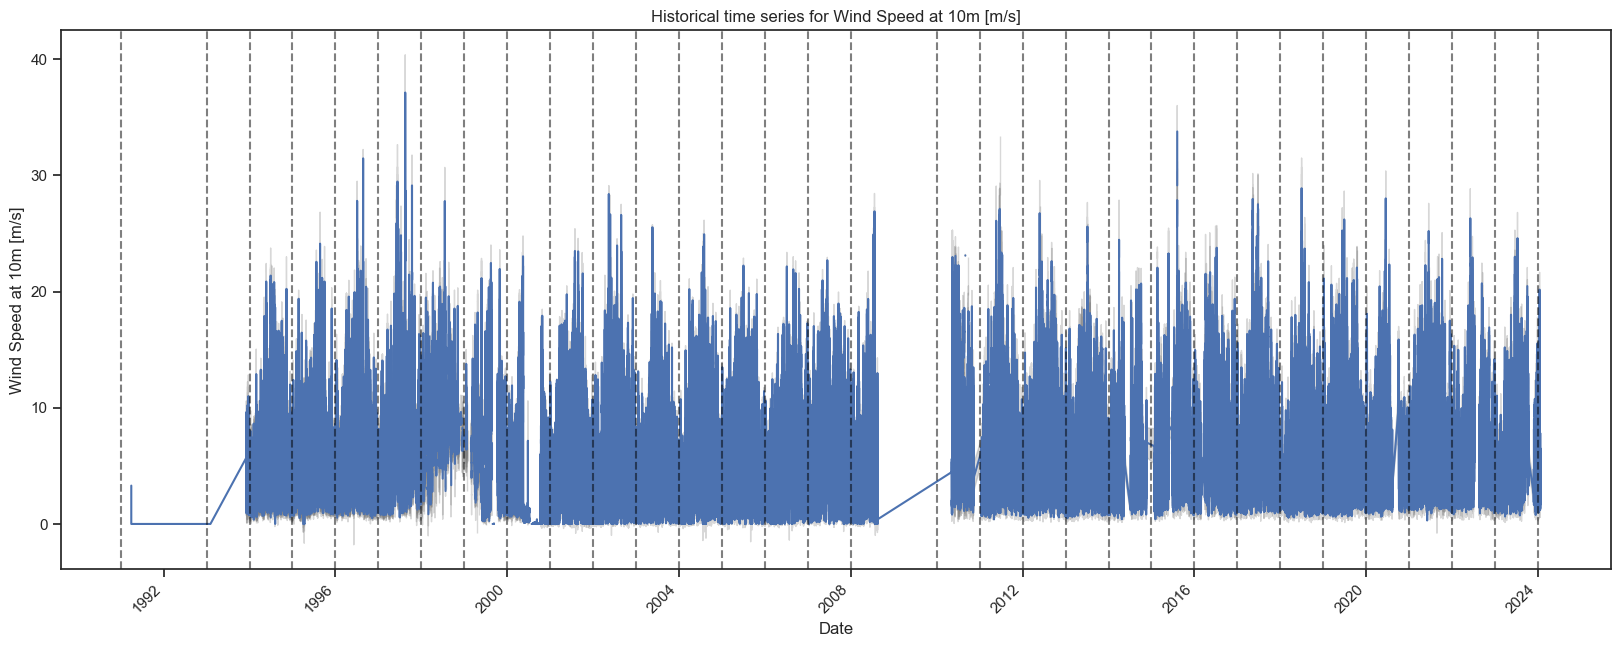

In [154]:
for variable in numeric_col:
    plot_timeseries_err(variable) # saving plots

## Time series subplots

In [ ]:
for variable in numeric_col:
    plot_timeseries_subplots(variable) # saving plots in plots/histograms_per_year

Remark:
* Ambient Temperature at ground [C] in lasts years available shows a pattern for winter season where tends to get lowers temperatures
* Rest variables needs more details